In [1]:
%load_ext autoreload
%autoreload 2
import pyreadstat
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import scipy
import pandas as pd
import seaborn as sns
from scipy.stats import norm, bernoulli
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os, sys
import matplotlib.patheffects as pe
from plot_utils import make_width_coverage_plot, get_data, transform_features, make_length_table, make_coverage_table, make_error_table
import warnings; warnings.simplefilter('ignore')
from tqdm import tqdm
from baselines import classical_ols_ci
from ppi import ppi_ols_ci
from reppi import ppi_opt_ols_ci_crossfit

In [2]:
np.random.seed(1)

In [3]:
def simulate_LM(n, d1, d2, rho, num_trails, alpha=0.1):

    length = np.zeros(4)
    coverage = np.zeros(4)
    mse = np.zeros(4)
    index1 = range(int(0.1 * n))
    index2 = range(int(0.1 * n), n)

    for i in range(num_trails):
        
        X = np.random.randn(n, d1) * np.sqrt(1 / (1 + rho) * 10)
        W = np.random.randn(n, d2) * np.sqrt(rho / (1 + rho) * 10)
        beta = np.random.randn(d1)
        gamma = np.random.randn(d2)
        beta = beta / np.linalg.norm(beta) 
        gamma = gamma / np.linalg.norm(gamma) 
        eps = np.random.randn(n)
        Y = X @ beta + W @ gamma + eps
        theta_true = gamma[0]
        Yhat = X @ beta
        Yhat_lab = Yhat[index1]
        Yhat_unlab = Yhat[index2]
        X_lab = W[index1]
        X_unlab = W[index2]
        Y_lab = Y[index1]
        
        # Classical OLS
        l, u = classical_ols_ci(X_lab, Y_lab, alpha=alpha)
        length[0] += u[0] - l[0]
        coverage[0] += l[0] <= theta_true <= u[0]
        mse[0] += np.abs((u[0]+l[0])/2 - theta_true)

        # PPI OLS
        l, u = ppi_ols_ci(X_lab, Y_lab, Yhat_lab, X_unlab, Yhat_unlab, alpha=alpha, lhat=1)
        length[1] += u[0] - l[0]
        coverage[1] += l[0] <= theta_true <= u[0]
        mse[1] += np.abs((u[0]+l[0])/2 - theta_true)

        # PPI++ OLS
        l, u = ppi_ols_ci(X_lab, Y_lab, Yhat_lab, X_unlab, Yhat_unlab, alpha=alpha)
        length[2] += u[0] - l[0]
        coverage[2] += l[0] <= theta_true <= u[0]
        mse[2] += np.abs((u[0]+l[0])/2 - theta_true)
        
        # optPPI OLS Crossfit
        l, u = ppi_opt_ols_ci_crossfit(X_lab, Y_lab, Yhat_lab, X_unlab, Yhat_unlab, alpha=alpha, method='linreg')
        length[3] += u[0] - l[0]
        coverage[3] += l[0] <= theta_true <= u[0]
        mse[3] += np.abs((u[0]+l[0])/2 - theta_true)

    length /= num_trails
    coverage /= num_trails
    mse /= num_trails
    return length, coverage, mse


In [4]:
n = 10000
d1 = 5
d2 = 5
num_trails = 100
alpha = 0.1
# plot the length and coverage for different rho
rhos = np.logspace(-1.5, 1.5, 30)
length_table = np.zeros((len(rhos), 4))
coverage_table = np.zeros((len(rhos), 4))
mse_table = np.zeros((len(rhos), 4))
for i, rho in enumerate(tqdm(rhos)):
    length_table[i], coverage_table[i], mse_table[i] = simulate_LM(n, d1, d2, rho, num_trails, alpha=alpha)

100%|██████████| 30/30 [03:56<00:00,  7.90s/it]


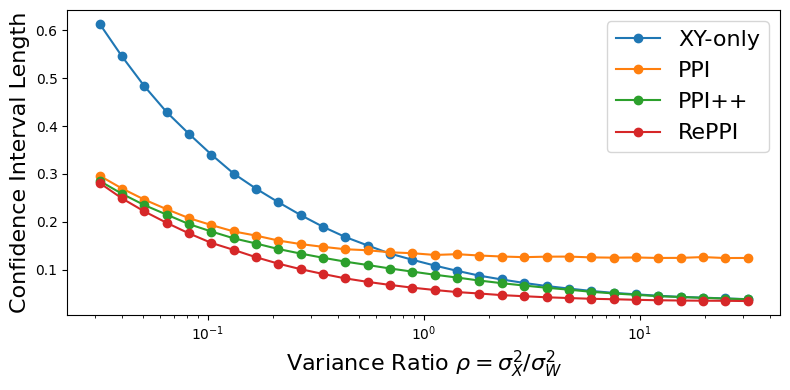

In [5]:
plt.figure(figsize=(8, 4))
plt.plot(rhos, length_table[:, 0], label='XY-only', marker='o')
plt.plot(rhos, length_table[:, 1], label='PPI', marker='o')
plt.plot(rhos, length_table[:, 2], label='PPI++', marker='o')
plt.plot(rhos, length_table[:, 3], label='RePPI', marker='o')
plt.xscale('log')
plt.xlabel(r'Variance Ratio $\rho=\sigma_X^2/\sigma_W^2$',fontsize=16)
plt.ylabel('Confidence Interval Length',fontsize=16)
plt.legend(prop={'size': 16})
plt.tight_layout()
plt.savefig('../results/length_rho.pdf')

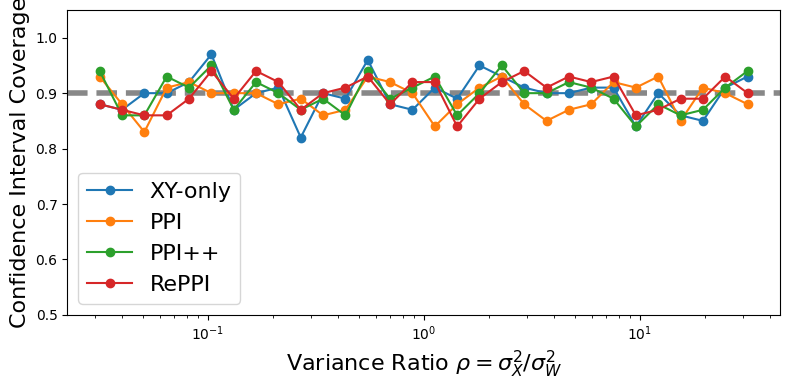

In [6]:
plt.figure(figsize=(8, 4))
plt.plot(rhos, coverage_table[:, 0], label='XY-only', marker='o')
plt.plot(rhos, coverage_table[:, 1], label='PPI', marker='o')
plt.plot(rhos, coverage_table[:, 2], label='PPI++', marker='o')
plt.plot(rhos, coverage_table[:, 3], label='RePPI', marker='o')
plt.xscale('log')
plt.ylim(0.5,1.05)
plt.xlabel(r'Variance Ratio $\rho=\sigma_X^2/\sigma_W^2$',fontsize=16)
plt.ylabel('Confidence Interval Coverage',fontsize=16)
plt.axhline(0.9, color="#888888", linestyle='dashed', linewidth=4, zorder=1, alpha=1.0)
plt.legend(prop={'size': 16})
plt.tight_layout()
plt.savefig('../results/coverage_rho.pdf')